<a href="https://colab.research.google.com/github/EMash103/Image/blob/main/CNN_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning Objectives:

At the end of the experiment, you will be able to:

1. Understand and use a pre-trained model
2. Fine-tune the top layers while using a pre-trained model


## Introduction

A common and highly effective approach to deep learning on small image datasets is to use a pre-trained model.

If the original dataset is large enough and general enough, the spatial hierarchy of features learned by the pre-trained model can effectively act as a generic model of the visual world, and hence, its features can prove useful for many different computer vision problems even though these new problems may involve completely different classes than those of the original task.

There are two ways to use a pre-trained model:
  * feature extraction and
  * fine-tuning

### Feature extraction

A CNN typically consists of a:
* Convolutional base
* Densely connected classifier

Key Idea -
* Features are learned by the convolutional base. So reuse it.
* Train a new classifier for your problem

![picture](https://drive.google.com/uc?export=view&id=12FzJVGUCzQGDArYSqdABntKwKGHzIjVX)

### Import libraries

In [1]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D,MaxPool2D
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let us reuse the VGG16 network which has been trained on the ImageNet, which contains multiple classes of cats and dogs among other things.

We expect the convolution base to have learned features that help it identify cats and dogs.

Keras provides us with a pre-trained VGG16 network!



In [2]:
from tensorflow.keras.applications.vgg16 import VGG16

In [3]:
# Load the convolutional base
conv_base = VGG16(
    weights = "imagenet",
    include_top = False, # Don't re-use the classifier (top layers)
    input_shape = (180,180,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# See a summary of the convolutional base
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

So how do we extract the features? Simple:

Pass the images through the convolutional base.

In [5]:
#@title Download the data


# Load the cats_vs_dogs dataset
dataset, info = tfds.load('cats_vs_dogs', split='train', with_info=True)

# Define the percentage of the dataset to be used
percentage_to_use = 0.4  # Adjust as needed

# Calculate the size of the subset
subset_size = int(percentage_to_use * info.splits['train'].num_examples)

# Take a subset of the dataset
subset_dataset = dataset.take(subset_size)

# Function to filter dataset by class label
def filter_by_label(example, label):
    return example['label'] == label

# Stratified sampling for cats (label 0)
cats_subset = subset_dataset.filter(lambda example: filter_by_label(example, label=0))

# Stratified sampling for dogs (label 1)
dogs_subset = subset_dataset.filter(lambda example: filter_by_label(example, label=1))

# Combine the stratified subsets
stratified_subset = tf.data.Dataset.concatenate(cats_subset, dogs_subset)



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.4NTDEI_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [6]:
# Function to resize an image
def resize_image(sample):
    image = sample['image']
    resized_image = tf.image.resize(image, (180, 180))  # Adjust the target size as needed
    sample['image'] = resized_image
    return sample

# Apply image resizing to the entire dataset
stratified_subset = stratified_subset.map(resize_image)


print(f"stratified_subset = {stratified_subset}")

stratified_subset = <_MapDataset element_spec={'image': TensorSpec(shape=(180, 180, 3), dtype=tf.float32, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


### Converting the image dataset into a workable format

In [7]:
# Define the sizes for training, validation, and testing sets
train_size = int(0.8 * subset_size)  # 80% for training
validation_size = int(0.1 * subset_size)  # 10% for validation
test_size = subset_size - train_size - validation_size  # Remaining for testing

batch_size = 32

# Create a new dataset with a simpler structure using map for training
train_dataset = (
    stratified_subset
    .take(train_size)
    .map(lambda x: (x['image'], x['label']))
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Create a new dataset with a simpler structure using map for validation
validation_dataset = (
    stratified_subset
    .skip(train_size)  # Skip the training set
    .take(validation_size)
    .map(lambda x: (x['image'], x['label']))
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Create a new dataset with a simpler structure using map for testing
test_dataset = (
    stratified_subset
    .skip(train_size + validation_size)  # Skip the training and validation sets
    .map(lambda x: (x['image'], x['label']))
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Access the element_spec attribute to get the shape of a batch for training
print("train_dataset =", train_dataset, "\n")

# Access the element_spec attribute to get the shape of a batch for validation
print("validation_dataset =", validation_dataset, "\n")

# Access the element_spec attribute to get the shape of a batch for testing
print("test_dataset =", test_dataset, "\n")



train_dataset = <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))> 

validation_dataset = <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))> 

test_dataset = <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))> 



### Passing the dataset through Conv Base i.e forward pass through pre-trained weights

Before forward pass, Preprocessing the dataset specific to VGG16 is also required.

In [8]:
from tensorflow.keras.applications.vgg16 import preprocess_input       # Importing function for preprocessing specific to the vgg16

In [9]:
# Verify batch size for training
for data_batch, labels_batch in train_dataset:
    print("=====train_dataset======")
    print("data batch shape (train):", data_batch.shape)
    print("labels batch shape (train):", labels_batch.shape, "\n")
    break

# Verify batch size for validation
for data_batch, labels_batch in validation_dataset:
    print("=====validation_dataset======")
    print("data batch shape (validation):", data_batch.shape)
    print("labels batch shape (validation):", labels_batch.shape, "\n")
    break

# Verify batch size for testing
for data_batch, labels_batch in test_dataset:
    print("=====test_dataset======")
    print("data batch shape (test):", data_batch.shape)
    print("labels batch shape (test):", labels_batch.shape)
    break



=====train_dataset======
data batch shape (train): (32, 180, 180, 3)
labels batch shape (train): (32,) 

=====validation_dataset======
data batch shape (validation): (32, 180, 180, 3)
labels batch shape (validation): (32,) 

=====test_dataset======
data batch shape (test): (32, 180, 180, 3)
labels batch shape (test): (32,)


In [10]:
# Extracting the features from pretrained models
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = preprocess_input(images) # preprocessing specific to the vgg16
        features = conv_base.predict(preprocessed_images)    # forward pass
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

# Doing the same for all datasets
train_feature, train_labels = get_features_and_labels(train_dataset)
val_feature, val_labels = get_features_and_labels(validation_dataset)
test_feature, test_labels = get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

### Defining and training the densely connected classifier



In [11]:
# Q: Defining the classifier using the Functional API
inputs = Input(shape=(5,5,512))
x = Flatten()(inputs)
x = Dense(256)(x)
x = Dropout(0.5)(x)
outputs = Dense(1,activation="sigmoid")(x)
model_without_conv_base = Model(inputs,outputs)  ## Model is imported from keras while importing libraries

model_without_conv_base.compile(loss="binary_crossentropy",
             optimizer="rmsprop",
             metrics=["accuracy"])

#### Call Back Function

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
# Define a function to return a commmonly used callback_list
def def_callbacks(filepath, mod_chk_mon = "val_loss", tensorboard = True, earlystop = 0 ):
    callback_list = []

    # Defualt callback
    callback_list.append(ModelCheckpoint(filepath,
                                         save_best_only = True,
                                         monitor=mod_chk_mon))
    if tensorboard:
      log_dir = "tensorLog_" + filepath
      callback_list.append(TensorBoard(log_dir=log_dir))

    if earlystop>0:
       callback_list.append(EarlyStopping(patience=earlystop))

    return callback_list

In [15]:
# fit the densely connected classsifier
history_wcb = model_without_conv_base.fit(
    train_feature,train_labels,     # Q: How did we get train_features? A: By forward-passing the images through the conv base
    epochs=2,
    validation_data=(val_feature,val_labels),
    callbacks =def_callbacks("feature_extraction_keras.keras")
)

Epoch 1/2
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9206 - loss: 19.7777 - val_accuracy: 0.9710 - val_loss: 4.2032
Epoch 2/2
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9825 - loss: 2.7141 - val_accuracy: 0.9817 - val_loss: 2.7075


Plotting Accuracy and Loss vs Epochs

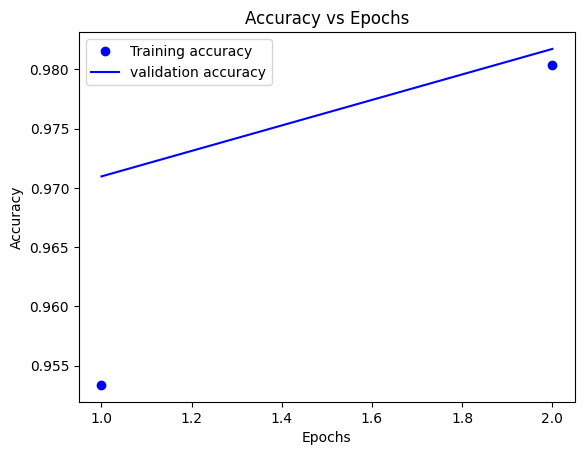

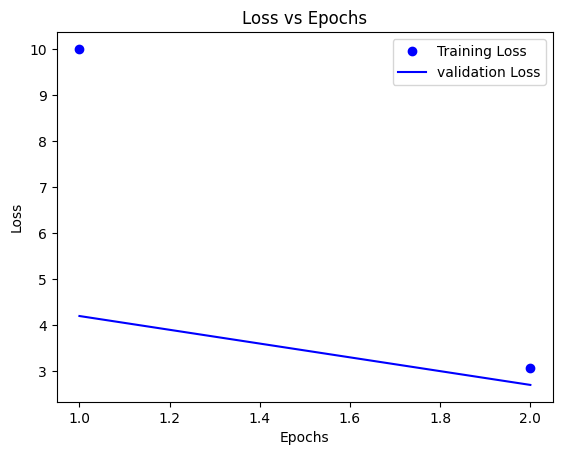

In [16]:
import pandas as pd
data = pd.DataFrame(history_wcb.history)
epochs = range(1,len(data)+1)
plt.plot(epochs,data['accuracy'],'bo',label="Training accuracy")
plt.plot(epochs,data['val_accuracy'],'b',label="validation accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.figure()
plt.plot(epochs,data['loss'],'bo',label="Training Loss")
plt.plot(epochs,data['val_loss'],'b',label="validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")

plt.show()

In [17]:
test_model = load_model("feature_extraction_keras.keras")
test_loss, test_acc = test_model.evaluate(test_feature,test_labels)
print(f"Test accuracy:{test_acc:.3f}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9823 - loss: 1.6271
Test accuracy:0.973


The pretrained conv base + newly trained classification head has achieved roughly **97%** accuracy!

Remember, for convnet_from_scratch_with_data_augmentation, it was ~ 85%

For convnet_from_scratch, it was ~ 70%

## Fine tuning

The key idea here is to fine tune some top layers of the conv base as well.

We do so by freezing most of the bottom layers, leaving only a few top layers to train. Lets see:

In [18]:
# Load the convolutional base
conv_base = VGG16(
    weights = "imagenet",
    include_top = False, # Don't re-use the classifier (top layers)
    input_shape = (180,180,3)
)

In [20]:
#Define the model
inputs = Input(shape=(180, 180, 3))
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = conv_base(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)
model = Model(inputs, outputs)

In [19]:
from tensorflow.keras.optimizers import RMSprop

In [21]:
#Freezing all layers until the fourth from the last
conv_base.trainable = True
for layer in conv_base.layers[:-4]:   #[1,2,3,4,5,6,7,8,9]
    layer.trainable = False

#  Model compilation and summary
model.compile(loss="binary_crossentropy",
              optimizer=RMSprop(learning_rate=1e-5), # use low learning rate to not vary the weights drastically
              metrics=["accuracy"])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 180, 180)  │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180, 180)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 180, 180)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 180, 180,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 180, 180,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 12800)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │  3,277,056 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,992,001 (68.63 MB)

 Trainable params: 10,356,737 (39.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [22]:
## Callback function
callbacks = [ModelCheckpoint(filepath="fine_tuning_keras.keras", save_best_only=True, monitor="val_loss")]

In [24]:
## Training
history = model.fit(train_dataset, epochs=3, validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/3
    233/Unknown 48s 184ms/step - accuracy: 0.9533 - loss: 1.0996

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


233/233 ━━━━━━━━━━━━━━━━━━━━ 67s 268ms/step - accuracy: 0.9534 - loss: 1.0999 - val_accuracy: 1.0000 - val_loss: 2.9933e-07
Epoch 2/3
233/233 ━━━━━━━━━━━━━━━━━━━━ 74s 247ms/step - accuracy: 0.8987 - loss: 2.3288 - val_accuracy: 1.0000 - val_loss: 3.2128e-04
Epoch 3/3
233/233 ━━━━━━━━━━━━━━━━━━━━ 82s 247ms/step - accuracy: 0.9340 - loss: 0.9686 - val_accuracy: 1.0000 - val_loss: 1.2732e-04


In [25]:
## Evaluation
model = load_model("fine_tuning_keras.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

# OPTIONAL EXERCISE: plot the losses by using appropriate callbacks and tensorboard

30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 1.0000 - loss: 1.1511e-05
Test accuracy: 1.000


# Using already run and saved models

For this save the model checkpoints in your drive (download the checkpoints and save to drive) give that path while loading.

Mount your G drive:

In [26]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/"

Mounted at /content/drive
/content/drive/My Drive


For example, you downloaded the `feature_extraction_keras` model and saved it in your drive inside a folder named 'model'. You can load it here like this:

    model_saved_1 = load_model('/content/drive/MyDrive/models/feature_extraction_keras')

 In this case the file path is simply : '/content/feature_extraction_keras'

In [27]:
model_fewa = load_model('/content/feature_extraction_keras.keras')

In [28]:
test_loss, test_acc = model_fewa.evaluate(test_feature, test_labels)
print(f"Test accuracy is:{test_acc:.3f}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9823 - loss: 1.6271
Test accuracy is:0.973


Great! feature_extraction model has achieved **97%** accuracy!

In [29]:
print("hello")

hello
